workflow0
-----------------------------------------
RMSE of Work Flow 0: 0.0255065911805


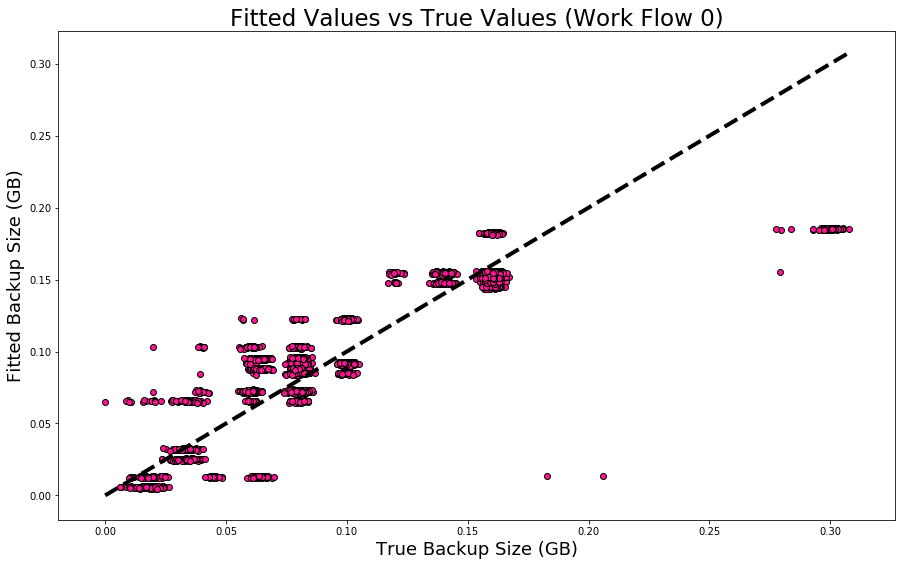

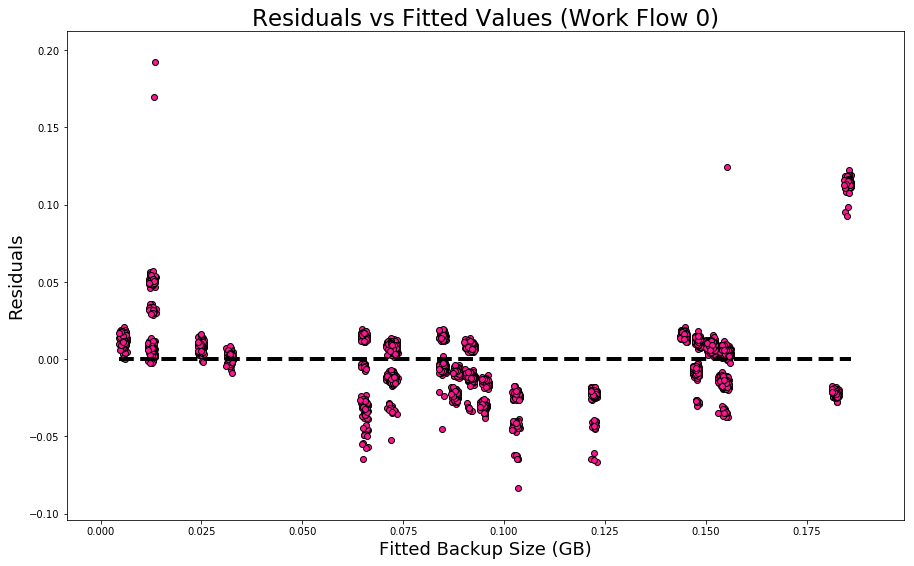

-----------------------------------------
workflow1
-----------------------------------------
RMSE of Work Flow 1: 0.113405721099


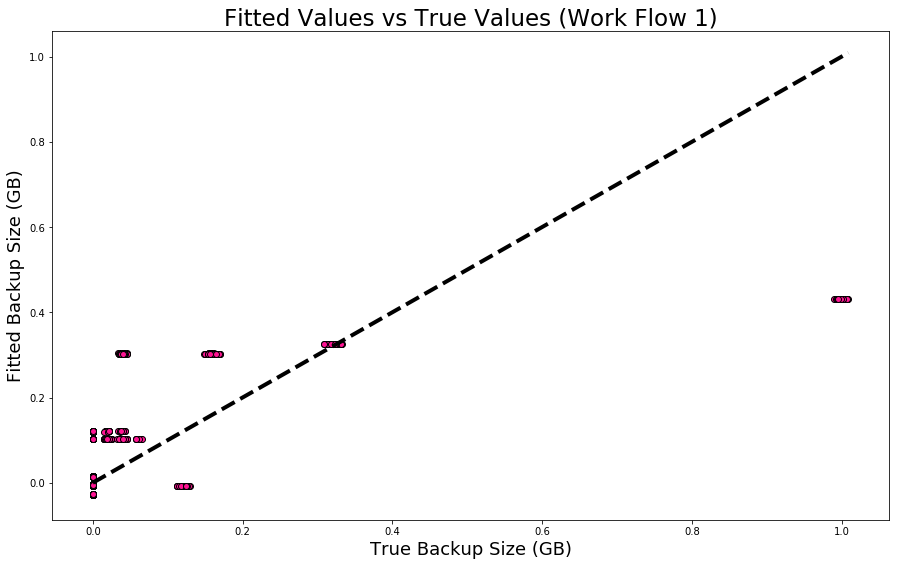

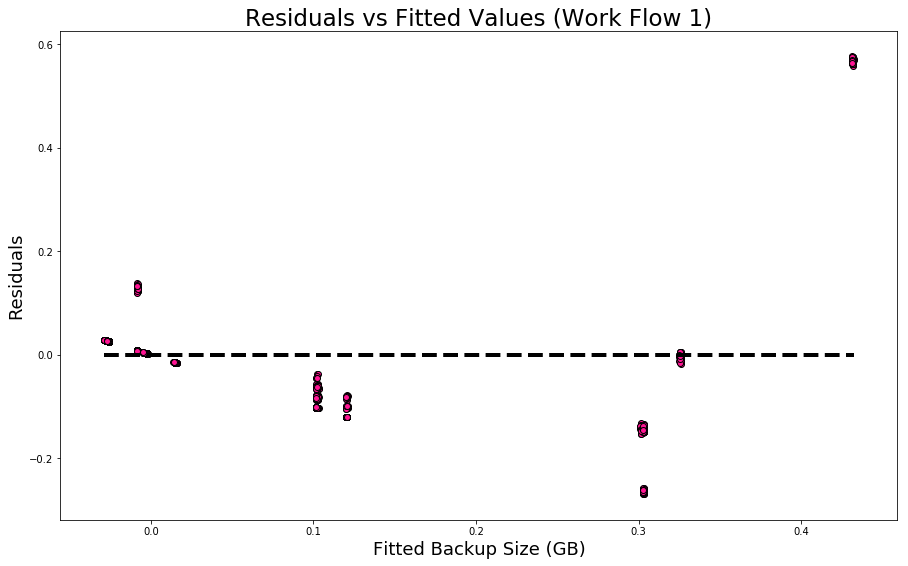

-----------------------------------------
workflow2
-----------------------------------------
RMSE of Work Flow 2: 0.0309727185747


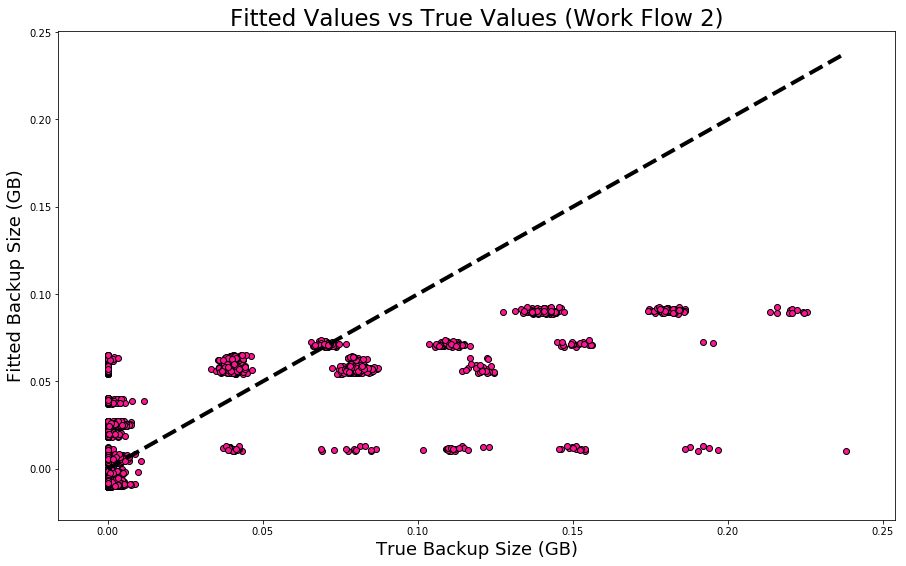

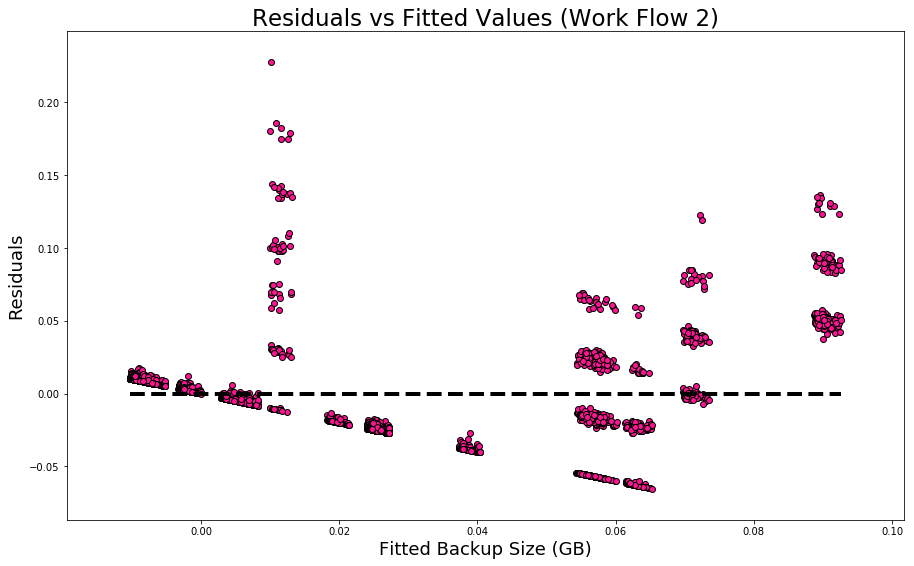

-----------------------------------------
workflow3
-----------------------------------------
RMSE of Work Flow 3: 0.00530162913819


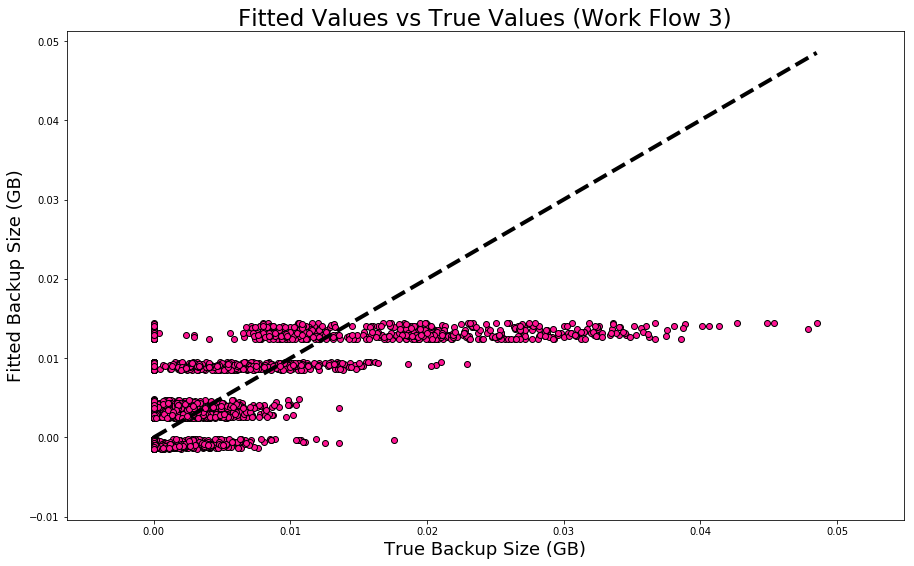

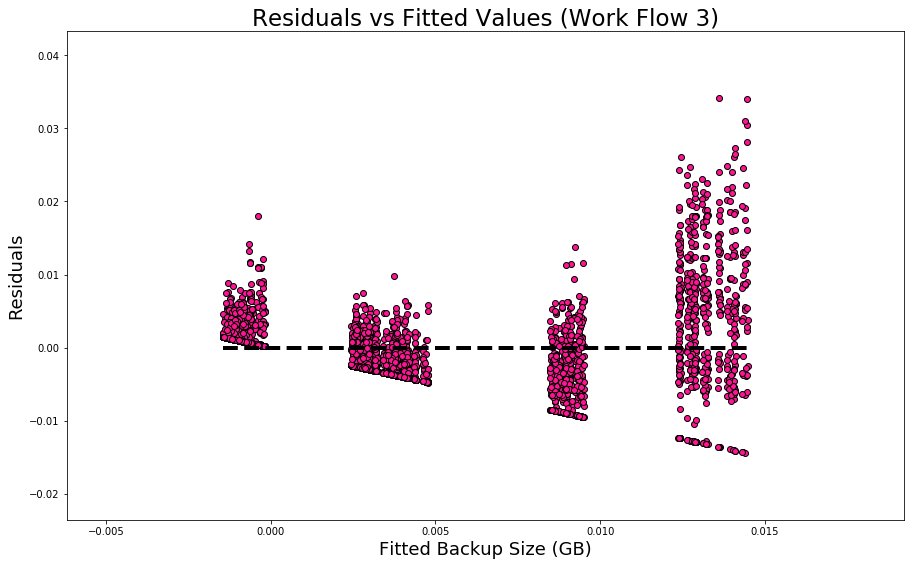

-----------------------------------------
workflow4
-----------------------------------------
RMSE of Work Flow 4: 0.0540565613482


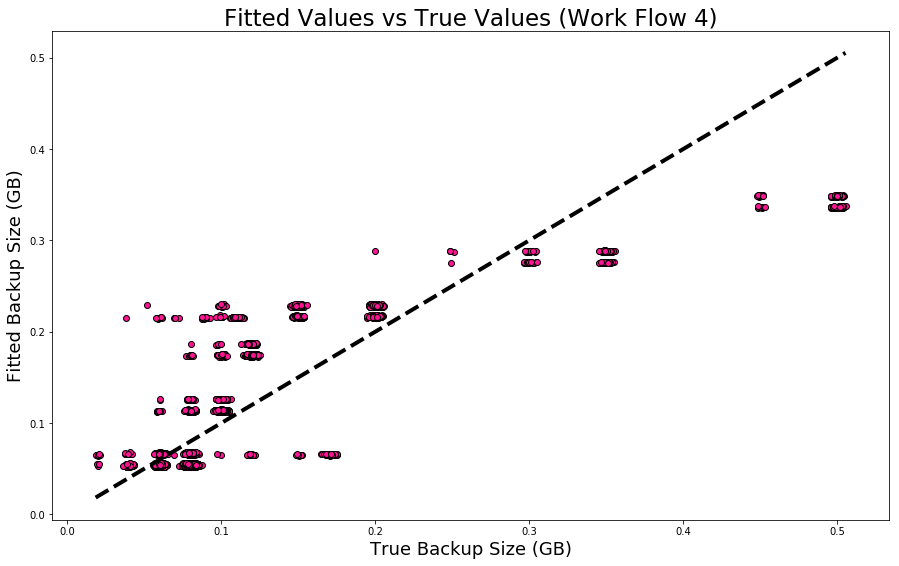

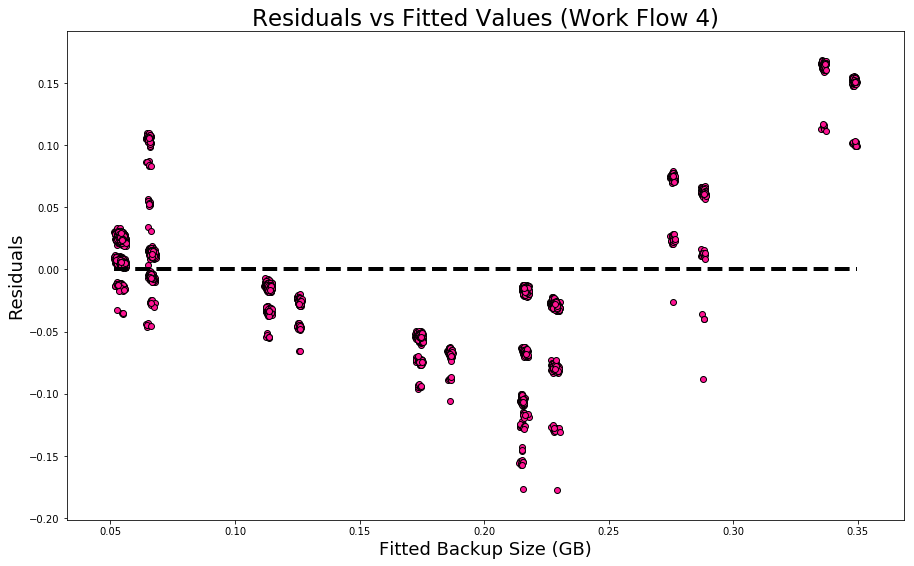

-----------------------------------------


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPRegressor


# load data from file
data = pd.read_csv('network_backup_dataset.csv')
data.columns = ['week', 'day_of_week_orig', 'start_time','work_flow_orig','file_name_orig','size','duration']

def replace_str_with_int(data, column, insert_pos, truncate_pos=0, map_day=None):
    new_col = []
    for item in data[column]:
        if map_day:
            new_col.append(map_day[item])
        else:
            new_col.append(int(item[truncate_pos:]))
    
    data.insert(insert_pos, column[:len(column) - 5], new_col)
    data.drop(column, 1, inplace = True)       

# 1 encode day of week
map_day = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
replace_str_with_int(data, 'day_of_week_orig', 2, 0, map_day)

# 2 encode work flow
replace_str_with_int(data, 'work_flow_orig', 3, 10)

# 3 encode file name
replace_str_with_int(data, 'file_name_orig', 4, 5)

# extract input and output
map_workflow_input = {}
map_workflow_output = {}

for workflow in range(5):
    df = data[data['work_flow'] == workflow]
    df = df.drop('work_flow', 1, inplace = False)
    input_arr = []
    output_arr = []
    for row in range(len(df)):
        input_arr.append(df.iloc[row, 0:4].values)
    output_arr = df.loc[:, 'size'].values
    map_workflow_input[workflow] = input_arr
    map_workflow_output[workflow] = output_arr

def one_hot_encoding(input_arr, one_hot_pos):
    enc = OneHotEncoder(n_values='auto', categorical_features=one_hot_pos, 
                        sparse=False, handle_unknown='error')
    return enc.fit_transform(input_arr)

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Using linear regression model
for workflow in range(5):
    print ('workflow' + str(workflow))
    print ('-----------------------------------------')
    cur_input = map_workflow_input[workflow]
    cur_output = map_workflow_output[workflow]
    # one-hot-encoding
    best_combine = 14
    one_hot_pos = []
    for pos in range(5):
        if ((best_combine >> pos) & 1) == 1:
            one_hot_pos.append(pos)
    tranformed_cur_input = one_hot_encoding(cur_input, one_hot_pos)
    # Ridge regularizer
    reg = linear_model.Ridge (alpha = 5)
    # use 10-fold cross-validation to evaluate
    kf = KFold(n_splits=10, shuffle=False)
    best_param = None
    lowest_rmse = float('inf')
    
    for train_index, test_index in kf.split(tranformed_cur_input):
        train_in = [tranformed_cur_input[i] for i in train_index]
        train_out = [output_arr[i] for i in train_index]
        test_in = [tranformed_cur_input[i] for i in test_index]
        test_out = [output_arr[i] for i in test_index]

        reg.fit(train_in, train_out)
        test_pre = reg.predict(test_in)
        cur_rmse = rmse(test_pre, test_out)
        if (cur_rmse < lowest_rmse):
            lowest_rmse = cur_rmse
            best_param = reg.get_params()
    
    reg.set_params(**best_param)
    reg.fit(tranformed_cur_input, cur_output)
    all_pre = reg.predict(tranformed_cur_input)
    residuals = np.subtract(cur_output, all_pre)
    final_rmse = rmse(all_pre, cur_output)
    print ('RMSE of Work Flow '+str(workflow)+': '+str(final_rmse))
    
    # plot fitted values vs true values
    plt.figure(figsize=(15,9))
    plt.scatter(cur_output, all_pre, color='deeppink', edgecolors='k')
    plt.plot([cur_output.min(), cur_output.max()], [cur_output.min(), cur_output.max()], 'k--', lw=4)
    plt.ylabel('Fitted Backup Size (GB)', fontsize = 18)
    plt.xlabel('True Backup Size (GB)', fontsize = 18)
    plt.title('Fitted Values vs True Values (Work Flow '+str(workflow)+')', fontsize = 23)
    plt.show()

    # plot residuals vs fitted values
    plt.figure(figsize=(15,9))
    plt.scatter(all_pre, residuals, color='deeppink', edgecolors='k')
    plt.plot([all_pre.min(), all_pre.max()], [0, 0], 'k--', lw=4)
    plt.ylabel('Residuals', fontsize = 18)
    plt.xlabel('Fitted Backup Size (GB)', fontsize = 18)
    plt.title('Residuals vs Fitted Values (Work Flow '+str(workflow)+')', fontsize = 23)
    plt.show()
    
    print ('-----------------------------------------')